# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [16]:
# Load pickled data
import pickle
import numpy as np
import csv

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'
traffic_sign_file = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(traffic_sign_file) as f:
    reader = csv.reader(f)
    next(reader) # skip header
    sign_list = [r for r in reader]
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Training samples shape: ", np.array(X_train).shape)
print("Training samples length: ", np.array(y_train).shape)
print("Validation samples shape: ", np.array(X_valid).shape)
print("Validation samples length: ", np.array(y_valid).shape)
print("Testing samples shape: ", np.array(X_test).shape)
print("Testing samples length: ", np.array(y_test).shape)
print("Class size in file:", [len(sign_list), len(sign_list[0])])
for line in sign_list:
    print('Class', line[0], ', Name:', line[1])

Training samples shape:  (34799, 32, 32, 3)
Training samples length:  (34799,)
Validation samples shape:  (4410, 32, 32, 3)
Validation samples length:  (4410,)
Testing samples shape:  (12630, 32, 32, 3)
Testing samples length:  (12630,)
Class size in file: [43, 2]
Class 0 , Name: Speed limit (20km/h)
Class 1 , Name: Speed limit (30km/h)
Class 2 , Name: Speed limit (50km/h)
Class 3 , Name: Speed limit (60km/h)
Class 4 , Name: Speed limit (70km/h)
Class 5 , Name: Speed limit (80km/h)
Class 6 , Name: End of speed limit (80km/h)
Class 7 , Name: Speed limit (100km/h)
Class 8 , Name: Speed limit (120km/h)
Class 9 , Name: No passing
Class 10 , Name: No passing for vehicles over 3.5 metric tons
Class 11 , Name: Right-of-way at the next intersection
Class 12 , Name: Priority road
Class 13 , Name: Yield
Class 14 , Name: Stop
Class 15 , Name: No vehicles
Class 16 , Name: Vehicles over 3.5 metric tons prohibited
Class 17 , Name: No entry
Class 18 , Name: General caution
Class 19 , Name: Dangerous 

In [17]:
import random
import cv2
from PIL import Image
from scipy import ndimage
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

# augment training data by slightly adjust the data
def addnoise (noise_type,image):
    """
    Generate noise to a given Image based on required noise type
    
    Input parameters:
        image: ndarray (input image data. It will be converted to float)
        
        noise_type: string
            'gauss'        Gaussian-distrituion based noise
            'poission'     Poission-distribution based noise
            's&p'          Salt and Pepper noise, 0 or 1
            'speckle'      Multiplicative noise using out = image + n*image
                           where n is uniform noise with specified mean & variance
    """
    row,col,ch= image.shape
    if noise_type == "gauss":       
        mean = 0.0
        var = 0.01
        sigma = var**0.5
        gauss = np.array(image.shape)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy.astype('uint8')
    elif noise_type == "s&p":
        s_vs_p = 0.5
        amount = 0.004
        out = image
        # Generate Salt '1' noise
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255
        # Generate Pepper '0' noise
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type =="speckle":
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    else:
        return image
    
# rotate
def slightrotate(X):
    ang = random.randint(-10, 10)   
    im = X
    im = ndimage.rotate(im, ang, axes=(1, 0), reshape=False)
    return im

def randomrotate(Xb, intensity, batch_size):
        """
        Random Rotation to Image
        """
        for i in Xb.shape[0]:
            delta = 30. * intensity
            Xb[i] = rotate(Xb[i], random.uniform(-delta, delta), mode = 'edge')
        return Xb
    
def imageflip(X, y):
    X_cp = X
    for i in range(X_cp.shape[0]):
        #print(X_cp[i].shape)
        image_obj = Image.fromarray(X_cp[i],"RGB")
        flippedimage_obj = image_obj.transpose(Image.FLIP_LEFT_RIGHT)   
        X_cp[i] = np.array(flippedimage_obj)
    y_cp = y
    return X_cp, y_cp

def image_rotate(img):
    row, col, channel = img.shape

    angle = np.random.uniform(-60, 60)
    rotation_point = (row / 2, col / 2)
    rotation_matrix = cv2.getRotationMatrix2D(rotation_point, angle, 1)

    rotated_img = cv2.warpAffine(img, rotation_matrix, (col, row))
    return rotated_img

def image_shift(X):
    x = np.array(X).shape[1]
    y = np.array(X).shape[2]
    X_cp = X
    for i in range(X_cp.shape[0]):
        x_shift = np.random.uniform(-0.3 * x, 0.3 * x)
        y_shift = np.random.uniform(-0.3 * y, 0.3 * y)
        shift_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
        X_cp[i] = cv2.warpAffine(X_cp[i], shift_matrix, (x, y))
    return X_cp

def image_shear(X):
    X_cp = X
    x, y, channel = X_cp.shape[1], X_cp.shape[2], X_cp.shape[3]    
    for i in range(X_cp.shape[0]):
        shear = np.random.randint(5,15)
        pts1 = np.array([[5, 5], [20, 5], [5, 20]]).astype('float32')
        pt1 = 5 + shear * np.random.uniform() - shear / 2
        pt2 = 20 + shear * np.random.uniform() - shear / 2
        pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
        M = cv2.getAffineTransform(pts1, pts2)
        X_cp[i] = cv2.warpAffine(X_cp[i], M, (y, x))
    return X_cp

def image_blur(X):
    X_cp = X
    for i in range(X_cp.shape[0]):
        r_int = np.random.randint(0, 2)
        odd_size = 2 * r_int + 1
        X_cp[i] = cv2.GaussianBlur(X_cp[i], (odd_size, odd_size), 0)
    return X_cp


def image_gamma(X):
    X_cp = X
    for i in range(X_cp.shape[0]):
        gamma = np.random.uniform(0.3, 1.5)
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        X_cp[i] = cv2.LUT(X_cp[i], table)
    return X_cp

def projection(Xb, width, height):
    offset_w = width * 0.1
    offset_h = height * 0.1
    Xb_cp = [] 
    for i in range(Xb.shape[0]): 
        src = np.array((
            (offset_w, offset_h),
            (offset_w, height - offset_h),
            (width - offset_w, height - offset_h),
            (width - offset_w, offset_h)
        ))
        dst = np.array((
            (0, 0),
            (0, height),
            (width, height),
            (width, 0)
        ))
        tform = ProjectiveTransform()
        tform.estimate(src, dst)
        x = warp(Xb[i], tform, output_shape=(height,width))
        Xb_cp.append(x)
    return Xb_cp

def augmenttraindata(Images, Labels, rate):
    Images_copy = []
    Labels_copy = []
    ind = 0
    for im in Images:
        for i in range(rate):
            #im1 = addnoise("speckle", im)
            im2 = slightrotate(im)
            #Images_copy.append(im1)
            Images_copy.append(im2)
            Labels_copy.append(Labels[ind])
            #Labels_copy.append(Labels[ind])
        ind = ind + 1
    return Images_copy, Labels_copy
X = np.array(X_train)
y = np.array(y_train)
X_train_cp, y_train_cp = augmenttraindata(X, y, 1)
X = np.array(X_train)
y = np.array(y_train)
print("rotated")
X_train_cp1, y_train_cp1 = imageflip(X, y)
print("flipped")
X = np.array(X_train)
X_train_cp2 = image_shear(X)
print("sheared")
y_train_cp2 = y_train_cp1
X = np.array(X_train)
X_train_cp3 = image_blur(X)
print("blured")
y_train_cp3 = y_train_cp1
X = np.array(X_train)
#X_train_cp4 = image_gamma(X)
#print("gammaed")
#y_train_cp4 = y_train_cp1
X = np.array(X_train)
X_train_cp5 = image_shift(X)
print("shifted")
y_train_cp5 = y_train_cp1

rotated
flipped
sheared
blured
shifted


In [18]:
# extend the training sampels
X_train_ext = []
X_train_ext.extend(X_train)
X_train_ext.extend(X_train_cp)
X_train_ext.extend(X_train_cp1)
X_train_ext.extend(X_train_cp2)
X_train_ext.extend(X_train_cp3)
#X_train_ext.extend(X_train_cp4)
X_train_ext.extend(X_train_cp5)
y_train_ext = []
y_train_ext.extend(y_train)
y_train_ext.extend(y_train_cp)
y_train_ext.extend(y_train_cp1)
y_train_ext.extend(y_train_cp2)
y_train_ext.extend(y_train_cp3)
#y_train_ext.extend(y_train_cp4)
y_train_ext.extend(y_train_cp5)

print("Original training samples shape: ", np.array(X_train).shape)
print("Original training samples length: ", np.array(y_train).shape)
print("New training samples shape: ", np.array(X_train_cp).shape)
print("New training samples length: ", np.array(y_train_cp).shape)
print("New training samples shape: ", np.array(X_train_cp1).shape)
print("New training samples length: ", np.array(y_train_cp1).shape)
print("New training samples shape: ", np.array(X_train_cp2).shape)
print("New training samples length: ", np.array(y_train_cp2).shape)
print("New training samples shape: ", np.array(X_train_cp3).shape)
print("New training samples length: ", np.array(y_train_cp3).shape)
#print("New training samples shape: ", np.array(X_train_cp4).shape)
#print("New training samples length: ", np.array(y_train_cp4).shape)
print("New training samples shape: ", np.array(X_train_cp5).shape)
print("New training samples length: ", np.array(y_train_cp5).shape)
print("Extended training samples shape: ", np.array(X_train_ext).shape)
print("Extended training samples length: ", np.array(y_train_ext).shape)
X_train = X_train_ext
y_train = y_train_ext

Original training samples shape:  (34799, 32, 32, 3)
Original training samples length:  (34799,)
New training samples shape:  (34799, 32, 32, 3)
New training samples length:  (34799,)
New training samples shape:  (34799, 32, 32, 3)
New training samples length:  (34799,)
New training samples shape:  (34799, 32, 32, 3)
New training samples length:  (34799,)
New training samples shape:  (34799, 32, 32, 3)
New training samples length:  (34799,)
New training samples shape:  (34799, 32, 32, 3)
New training samples length:  (34799,)
Extended training samples shape:  (208794, 32, 32, 3)
Extended training samples length:  (208794,)


Text(0.5,1,'shift image')

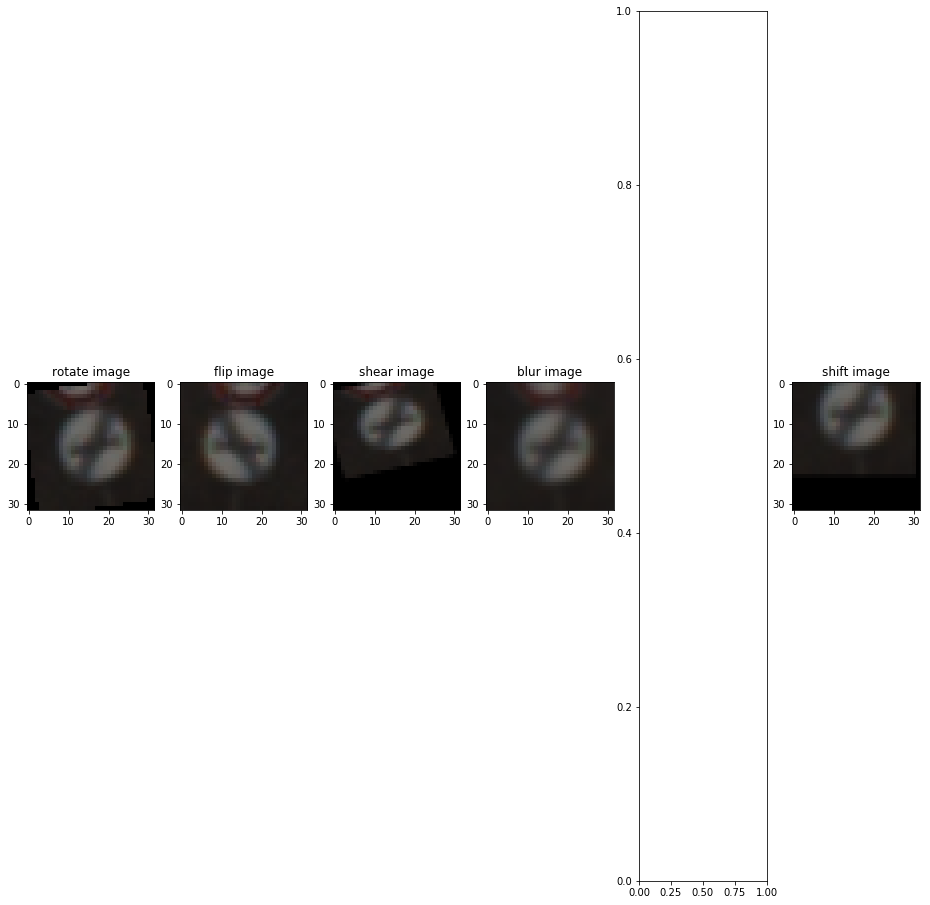

In [19]:
# plot the samples

%matplotlib inline

import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16,16))
ax1.imshow(X_train_cp[1]/255)
ax1.set_title('rotate image')
ax2.imshow(X_train_cp1[1]/255)
ax2.set_title('flip image')
ax3.imshow(X_train_cp2[1]/255)
ax3.set_title('shear image')
ax4.imshow(X_train_cp3[1]/255)
ax4.set_title('blur image')
#ax5.imshow(X_train_cp4[1]/255)
#ax5.set_title('gamma image')
ax6.imshow(X_train_cp5[1]/255)
ax6.set_title('shift image')

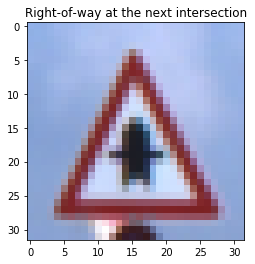

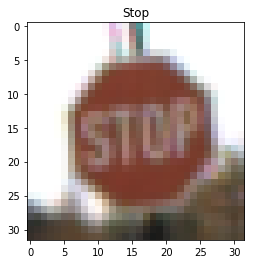

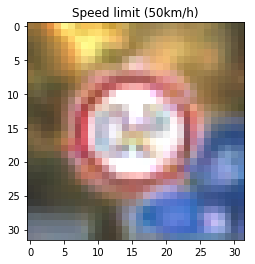

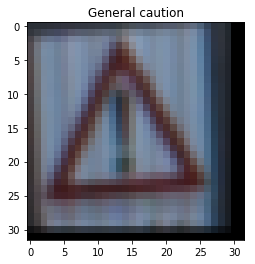

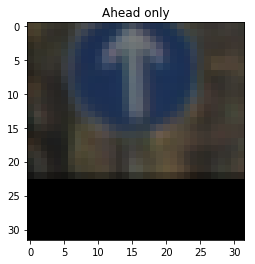

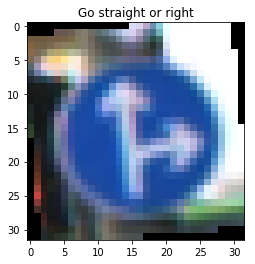

In [20]:
# Random check training data
for i in range(6):
    index = random.randint(0, np.array(X_train).shape[0])
    im = X_train[index]
    classind = y_train[index]
    plt.imshow(im/255)
    plt.title(sign_list[classind][1])
    plt.show()

In [21]:
# clean data
del X
del y
del X_train_cp
del y_train_cp
del X_train_cp1
del y_train_cp1
del X_train_cp2
del y_train_cp2
del X_train_cp3
del y_train_cp3
#del X_train_cp4
#del y_train_cp4
del X_train_cp5
del y_train_cp5
del X_train_ext
del y_train_ext

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [22]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = np.array(X_train).shape[0]

# TODO: Number of validation examples
n_validation = np.array(X_valid).shape[0]

# TODO: Number of testing examples.
n_test = np.array(X_test).shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = [np.array(X_train).shape[1], np.array(X_train).shape[2]]
image_size = np.array(X_train).shape[1] * np.array(X_train).shape[2]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(sign_list)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 208794
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

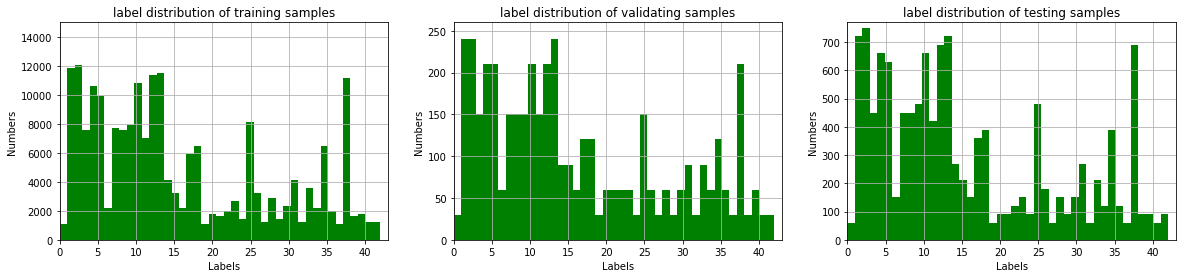

<Figure size 432x288 with 0 Axes>

In [23]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.

# histogram of samples
fig=plt.figure()
fig.add_subplot(1, 3, 1)
fig.set_size_inches(20, 4)
plt.hist(y_train, n_classes, density=False, facecolor='g')
plt.xlabel('Labels')
plt.ylabel('Numbers')
plt.title('label distribution of training samples')
plt.axis([0, 43, 0, 15000])
plt.grid(True)
fig.add_subplot(1, 3, 2)
#fig.set_size_inches(20, 4)
plt.hist(y_valid, n_classes, density=False, facecolor='g')
plt.xlabel('Labels')
plt.ylabel('Numbers')
plt.title('label distribution of validating samples')
plt.axis([0, 43, 0, 260])
plt.grid(True)
fig.add_subplot(1, 3, 3)
#fig.set_size_inches(20, 4)
plt.hist(y_test, n_classes, density=False, facecolor='g')
plt.xlabel('Labels')
plt.ylabel('Numbers')
plt.title('label distribution of testing samples')
plt.axis([0, 43, 0, 770])
plt.grid(True)
plt.show()
plt.savefig('./results/input_data_statistic.png')

In [24]:
# uniform the sample data by replicate the less number classes
def getclassimg(X, y, ind):
    classimg = []
    classy = []
    for i in range(len(y)):
        if(y[i]==ind):
            classimg.append(X[i])
            classy.append(ind)
    return classimg, classy

def extendtrainX(X, y, newlen):
    imgs = []
    newX = X
    newy = y
    oldlen = np.array(newX).shape[0]
    restlen = newlen - oldlen
    ind = 0
    while(restlen>oldlen):
        newX.append(X[ind])
        newy.append(y[ind])   
        ind = ind + 1
        if(ind==oldlen):
            restlen = restlen - oldlen
            ind = 0
    for i in range(restlen):
        newX.append(X[i])
        newy.append(y[i])
    return newX, newy

hist, bin_edges = np.histogram(y_train, bins=n_classes)
print(hist)
#print(bin_edges)

mostlen = np.amax(hist)
print(mostlen)

newX_train = []
newy_train = []
for ind in range(n_classes):
    classimg, classy = getclassimg(X_train, y_train, ind)
    classimgext, classyext = extendtrainX(classimg, classy, mostlen)
    newX_train = newX_train + classimgext
    newy_train = newy_train + classyext

[ 1080 11880 12060  7560 10620  9900  2160  7740  7560  7920 10800  7020
 11340 11520  4140  3240  2160  5940  6480  1080  1800  1620  1980  2700
  1440  8100  3240  1260  2880  1440  2340  4140  1260  3594  2160  6480
  1980  1080 11160  1620  1800  1260  1260]
12060


In [25]:
# update the training data
X_train = newX_train
y_train = newy_train
del newX_train
del newy_train
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(518580, 32, 32, 3)
(518580,)


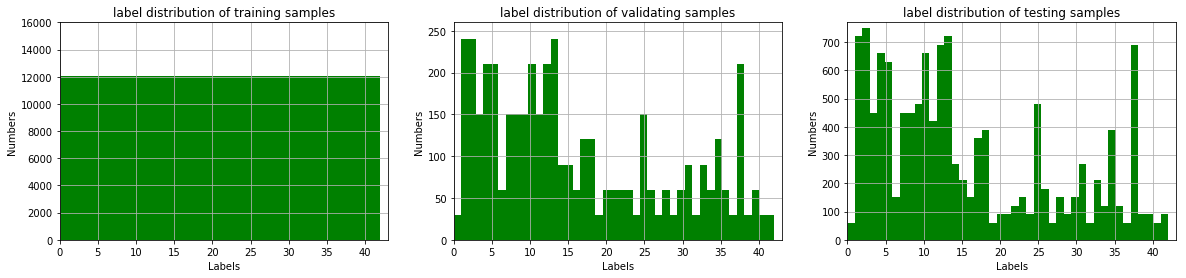

<Figure size 432x288 with 0 Axes>

In [26]:
# redo the histogram of samples
fig=plt.figure()
fig.add_subplot(1, 3, 1)
fig.set_size_inches(20, 4)
plt.hist(y_train, n_classes, density=False, facecolor='g')
plt.xlabel('Labels')
plt.ylabel('Numbers')
plt.title('label distribution of training samples')
plt.axis([0, 43, 0, 16000])
plt.grid(True)
fig.add_subplot(1, 3, 2)
#fig.set_size_inches(20, 4)
plt.hist(y_valid, n_classes, density=False, facecolor='g')
plt.xlabel('Labels')
plt.ylabel('Numbers')
plt.title('label distribution of validating samples')
plt.axis([0, 43, 0, 260])
plt.grid(True)
fig.add_subplot(1, 3, 3)
#fig.set_size_inches(20, 4)
plt.hist(y_test, n_classes, density=False, facecolor='g')
plt.xlabel('Labels')
plt.ylabel('Numbers')
plt.title('label distribution of testing samples')
plt.axis([0, 43, 0, 770])
plt.grid(True)
plt.show()
plt.savefig('./results/input_data_statistic_uniform.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [27]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

import tensorflow as tf
import sys
from scipy.ndimage import filters
from scipy import misc

rate = [0.299, 0.587, 0.114]
xmin = 0
xmax = 1
# normalization
def normalize(X, xmin, xmax):
    return xmin + X * (xmax-xmin) / 255
# standardization
def standardize(X):
    X -= np.mean(X) # zero-center
    X /= np.std(X) # normalize
    return (X)
# RGB to GRAY
def rgb2gray(X, rate):
    X_gray = np.dot(X[...,:3], rate)    
    return X_gray
def newsample(X):    
    Xnew = addnoise('speckle',X)
    Xnew = slightrotate(Xnew)
    return Xnew
# preprocess
def preprocess(X, rate, xmin, xmax):
    X = normalize(X, xmin, xmax)
    X = standardize(X)
    X = rgb2gray(X, rate)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


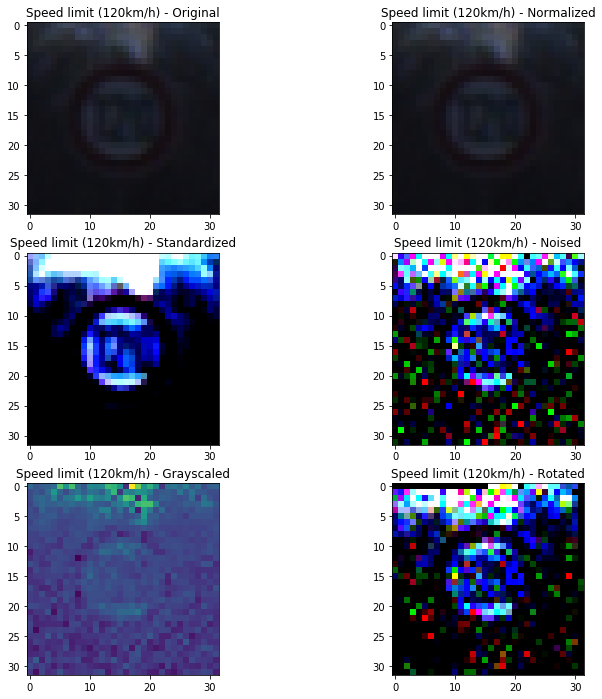

In [28]:
RANDOM_PLOT_INPUT = True
if RANDOM_PLOT_INPUT:
    index = random.randint(0, n_validation)
    im = X_valid[index]
    label = y_valid[index]
    fig=plt.figure(figsize=(12, 12))
    fig.add_subplot(3, 2, 1)
    plt.imshow(im)
    plt.title(sign_list[int(label)][1]+" - Original")
    fig.add_subplot(3, 2, 2)
    normim = normalize(im, xmin, xmax)
    plt.imshow(normim)
    plt.title(sign_list[int(label)][1]+" - Normalized")
    fig.add_subplot(3, 2, 3)
    standim = standardize(normim)
    plt.imshow(standim)
    plt.title(sign_list[int(label)][1]+" - Standardized")
    fig.add_subplot(3, 2, 4)
    noiseim = addnoise('speckle',standim)
    plt.imshow(noiseim)
    plt.title(sign_list[int(label)][1]+" - Noised")
    fig.add_subplot(3, 2, 5)
    grayim = rgb2gray(noiseim, rate)
    plt.imshow(grayim)
    plt.title(sign_list[int(label)][1]+" - Grayscaled")
    fig.add_subplot(3, 2, 6)
    rotateim = slightrotate(noiseim)
    plt.imshow(rotateim)
    plt.title(sign_list[int(label)][1]+" - Rotated")
    plt.show()

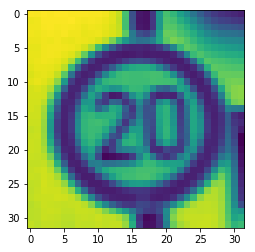

In [29]:
# preprocessing images
X_train_gray = []
for im in X_train:
    preim = preprocess(im, rate, xmin, xmax)
    X_train_gray.append(preim)
X_train_gray = np.expand_dims(X_train_gray, axis=3)
im = X_train_gray[1]
plt.imshow(np.array(im)[:,:,0])
plt.show()

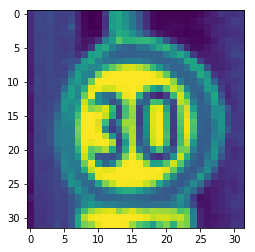

In [30]:
X_test_gray = []
for im in X_test:
    im = preprocess(im, rate, xmin, xmax)
    X_test_gray.append(im)
X_test_gray = np.expand_dims(X_test_gray, axis=3)
im = X_test_gray[1]
plt.imshow(np.array(im)[:,:,0])
plt.show()

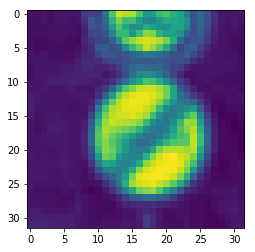

In [31]:
X_valid_gray = []
for im in X_valid:
    im = preprocess(im, rate, xmin, xmax)
    X_valid_gray.append(im)
X_valid_gray = np.expand_dims(X_valid_gray, axis=3)
im = X_valid_gray[1]
plt.imshow(np.array(im)[:,:,0])
plt.show()

In [32]:
print(X_train_gray.shape)
#sys.exit()
# One-Hot encoding the labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
encoder.fit(y_test)
test_labels = encoder.transform(y_test)
print('Input data preprocessed.')

(518580, 32, 32, 1)
Input data preprocessed.


(32, 32)
(32, 32)
(32, 32)


Text(0.5,1,'validating image')

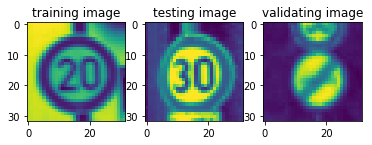

In [33]:
# plot the preprocessed dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
img = X_train_gray[1,:,:,0]
print(img.shape)
ax1.imshow(img)
ax1.set_title('training image')
img = X_test_gray[1,:,:,0]
print(img.shape)
ax2.imshow(img)
ax2.set_title('testing image')
img = X_valid_gray[1,:,:,0]
print(img.shape)
ax3.imshow(img)
ax3.set_title('validating image')

### Model Architecture

In [42]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten
# Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((image_size, n_classes))) # weight: [input size, output size]
biases = tf.Variable(tf.zeros(n_classes)) # bias: [output size]
keep_prob = tf.placeholder(tf.float32) # probability to keep units
def conv2d(x, weight_dim, bias_dim, strides, padding, mu, sigma):
    F_W = tf.Variable(tf.truncated_normal(weight_dim, mean = mu, stddev = sigma))  
    F_b = tf.Variable(tf.zeros(bias_dim))
    return tf.nn.conv2d(x, F_W, strides, padding) + F_b
def activate(x):
    return tf.nn.relu(x)
def maxpooling(x, ksize, strides, padding):
    return tf.nn.max_pool(x, ksize, strides, padding)
def fullconnect(x, shape, mu, sigma, keep_prob):
    W = tf.Variable(tf.truncated_normal(shape, mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(shape[1]))
    # apply dropout to hidden layer
    x_drop = tf.nn.dropout(x, keep_prob)
    return tf.matmul(x_drop, W) + b

def LeNet(x):    
    #declaring global variables to access them later to visualize the features
    global c1,ca1,cam1,c2,ca2,cam2,cam2_f,f1,fa1,f2,fa2
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6. 
    w_d = [5, 5, 3, 6] # conv filter (height, width, input_depth, output_depth)
    b_d = [6] # [output_depth]
    s_d = [1, 1, 1, 1] # (batch, height, width, depth)
    padding = 'VALID'
    c1 = conv2d(x, w_d, b_d, s_d, padding, mu, sigma)
    # Activation.
    ca1 = activate(c1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1, 2, 2, 1]# max filter (batch_size, height, width, depth)
    s_d = [1, 2, 2, 1] # (batch, height, width, depth)
    cam1 = maxpooling(ca1, ksize, s_d, 'VALID')
    # Layer 2: Convolutional. Output = 10x10x16.
    w_d = [5, 5, 6, 16] # conv filter (height, width, input_depth, output_depth)
    b_d = [16] # [output_depth]
    s_d = [1, 1, 1, 1] # (batch, height, width, depth)
    padding = 'VALID'
    c2 = conv2d(cam1, w_d, b_d, s_d, padding, mu, sigma)    
    # Activation.
    ca2 = activate(c2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2, 1]# max filter (batch_size, height, width, depth)
    s_d = [1, 2, 2, 1] # (batch, height, width, depth)
    cam2 = maxpooling(ca2, ksize, s_d, 'VALID')
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    cam2_f = flatten(cam2)    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    shape = [400, 120]
    f1 = fullconnect(cam2_f, shape, mu, sigma, 1)    
    # Activation.
    fa1 = activate(f1)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    shape = [120, 84]
    f2 = fullconnect(fa1, shape, mu, sigma, 1)    
    # Activation.
    fa2 = activate(f2)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    shape = [84, n_classes]
    logits = fullconnect(fa2, shape, mu, sigma, 1)    
    return logits

def CNN_mod(x):    
    #declaring global variables to access them later to visualize the features
    global c1,ca1,cam1,c2,ca2,c3,ca3,c4,ca4,cam4,c5,ca5,cam5,f1,fa1,f2,fa2
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32. 
    w_d = [3, 3, 3, 32] # conv filter (height, width, input_depth, output_depth)
    b_d = [32] # [output_depth]
    s_d = [1, 1, 1, 1] # (batch, height, width, depth)
    padding = 'VALID'
    c1 = conv2d(x, w_d, b_d, s_d, padding, mu, sigma)
    # Activation.
    ca1 = activate(c1)
    
    # Layer 2: Convolutional. Input = 30x30x32. Output = 28x28x32. 
    w_d = [3, 3, 32, 32] # conv filter (height, width, input_depth, output_depth)
    b_d = [32] # [output_depth]
    s_d = [1, 1, 1, 1] # (batch, height, width, depth)
    padding = 'VALID'
    c2 = conv2d(ca1, w_d, b_d, s_d, padding, mu, sigma)
    # Activation.
    ca2 = activate(c2)
        
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    ksize = [1, 2, 2, 1]# max filter (batch_size, height, width, depth)
    s_d = [1, 2, 2, 1] # (batch, height, width, depth)
    cam1 = maxpooling(ca2, ksize, s_d, 'VALID')
    
    # Layer 3: Convolutional. Input = 14x14x32. Output = 12x12x64.
    w_d = [3, 3, 32, 64] # conv filter (height, width, input_depth, output_depth)
    b_d = [64] # [output_depth]
    s_d = [1, 1, 1, 1] # (batch, height, width, depth)
    padding = 'VALID'
    c3 = conv2d(cam1, w_d, b_d, s_d, padding, mu, sigma)    
    # Activation.
    ca3 = activate(c3)
    
    # Layer 4: Convolutional. Input = 12x12x64. Output = 10x10x64.
    w_d = [3, 3, 64, 64] # conv filter (height, width, input_depth, output_depth)
    b_d = [64] # [output_depth]
    s_d = [1, 1, 1, 1] # (batch, height, width, depth)
    padding = 'VALID'
    c4 = conv2d(ca3, w_d, b_d, s_d, padding, mu, sigma)    
    # Activation.
    ca4 = activate(c4)
    
    # Pooling. Input = 10x10x64. Output = 5x5x64.
    ksize = [1, 2, 2, 1]# max filter (batch_size, height, width, depth)
    s_d = [1, 2, 2, 1] # (batch, height, width, depth)
    cam4 = maxpooling(ca4, ksize, s_d, 'VALID')
    
    # Layer 5: Convolutional. Input = 5x5x64. Output = 3x3x128.
    w_d = [3, 3, 64, 128] # conv filter (height, width, input_depth, output_depth)
    b_d = [128] # [output_depth]
    s_d = [1, 1, 1, 1] # (batch, height, width, depth)
    padding = 'VALID'
    c5 = conv2d(cam4, w_d, b_d, s_d, padding, mu, sigma)    
    # Activation.
    ca5 = activate(c5)  
    
    # TODO: Flatten. Input = 3x3x128. Output = 1152.
    cam5 = flatten(ca5)    
    
    # Layer 6: Fully Connected. Input = 1152. Output = 512.
    shape = [1152, 512]
    f1 = fullconnect(cam5, shape, mu, sigma, 1)    
    # Activation.
    fa1 = activate(f1)
    
    # Layer 7: Fully Connected. Input = 1024. Output = 128.
    shape = [512, 128]
    f2 = fullconnect(fa1, shape, mu, sigma, 1)    
    # Activation.
    fa2 = activate(f2)
    
    # Layer 8: Fully Connected. Input = 128. Output = 43.
    shape = [128, n_classes]
    logits = fullconnect(fa2, shape, mu, sigma, 1)    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...
(518580, 32, 32, 3)

EPOCH 1 ...
Validation Accuracy = 0.920

EPOCH 2 ...
Validation Accuracy = 0.941

EPOCH 3 ...
Validation Accuracy = 0.950

EPOCH 4 ...
Validation Accuracy = 0.953

EPOCH 5 ...
Validation Accuracy = 0.971

EPOCH 6 ...
Validation Accuracy = 0.973

EPOCH 7 ...
Validation Accuracy = 0.969

EPOCH 8 ...
Validation Accuracy = 0.968

EPOCH 9 ...
Validation Accuracy = 0.971

EPOCH 10 ...
Validation Accuracy = 0.963

EPOCH 11 ...
Validation Accuracy = 0.966

EPOCH 12 ...
Validation Accuracy = 0.981

Model saved


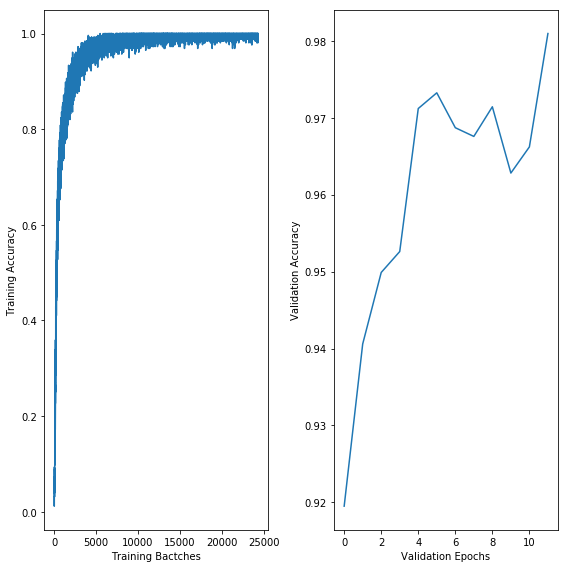

Test Accuracy = 0.964


In [43]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
lrate = 0.001
logits = CNN_mod(x)
#logits = LeNet(x)
softmax_prob = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lrate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
EPOCHS = 20
BATCH_SIZE = 256
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
save_file = './lenet.ckpt'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print(np.array(X_train).shape)
    print()
    train_ind = []
    train_acc = []
    valid_ind = []
    valid_acc = []
    tind = 1
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            training_accuracy = evaluate(batch_x, batch_y)
            train_acc.append(training_accuracy)
            train_ind.append(tind)
            tind = tind + 1
            
        validation_accuracy = evaluate(X_valid, y_valid)
        valid_acc.append(validation_accuracy)
        valid_ind.append(i)
        #if (i+1) % 10 == 0:
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        # early termination
        if(validation_accuracy>0.98):
            break  
    saver.save(sess, save_file)
    print("Model saved")
    fig=plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(train_ind, train_acc)
    plt.xlabel("Training Bactches")
    plt.ylabel("Training Accuracy")
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(valid_ind, valid_acc)
    plt.xlabel("Validation Epochs")
    plt.ylabel("Validation Accuracy") 
    plt.tight_layout()
    plt.show()
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))   

    

    

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

d:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Right-of-way at the next intersection 11
Priority road 12
Stop 14
No entry 17
Road work 25


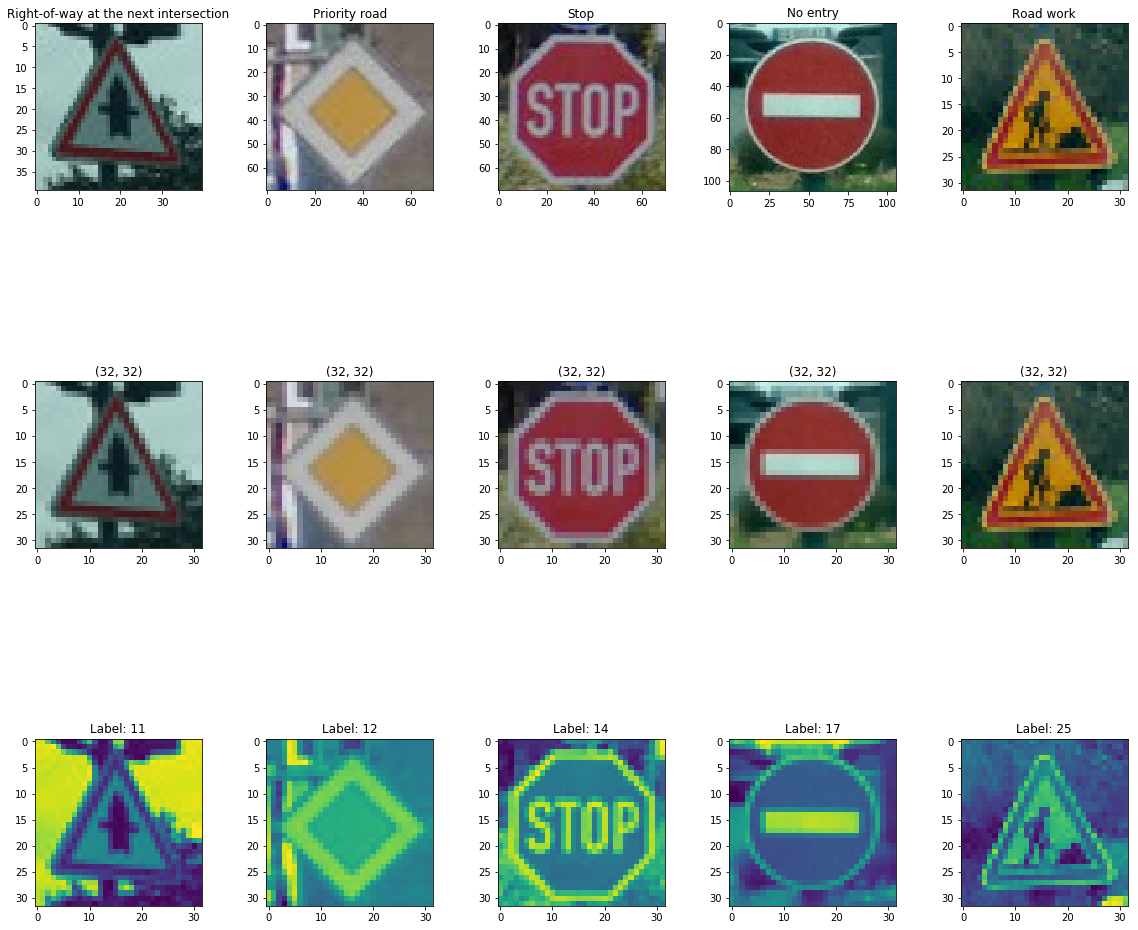

iamge shape is:  (32, 32)
iamge size is:  1024
data size is 5 32 32 3


In [44]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
from PIL import ImageOps
sample_image_path = './new_image/'
traffic_sign_file = 'signnames.csv'
def find_sign(label, filename): 
    o = open(filename, 'r') 
    myData = csv.reader(o) 
    index = 0 
    #print('finding the sign label mach: ', label)
    for row in myData:
        if index>0:
            if str(row[0])==str(label): 
                #print('found matched')
                return row[0], row[1]
        #print(row[0])
        index+=1
    return -1, 'not matched'
def pick_sample_from_file(sample_image_path, samplefilename, signfilename):    
    sample_image = Image.open(sample_image_path+samplefilename)
    signlabel, signname = find_sign(samplefilename.split('.')[0], signfilename)
    return sample_image, signlabel, signname
sample_image_files = os.listdir(sample_image_path)
xmin = 0
xmax = 1
# normalization
def normalize(X, xmin, xmax):
    return xmin + X * (xmax-xmin) / 255
# standardization
def standardize(X):
    X -= np.mean(X) # zero-center
    X /= np.std(X) # normalize
    return (X)
# RGB to GRAY
def rgb2gray(X, rate):
    #X_gray = []
    #rim = X[:,:,0]
    #gim = X[:,:,1]
    #bim = X[:,:,2]
    #X_gray = (rate[0] * rim + rate[1] * gim + rate[2] * bim)
    X_gray = np.dot(X[...,:3], [0.299, 0.587, 0.114])
    return X_gray
# preprocess
def preprocess(X, rate, xmin, xmax):
    X = normalize(X, xmin, xmax)
    X = standardize(X)
    X = rgb2gray(X, rate)
    return X
fig=plt.figure(figsize=(16, 16))
size = 32, 32
X_verify = []
X_verifygray = []
y_verify = []
signnames = []
for ind in range(5):
    # random pick a image
    rind = random.randint(0, 4)
    sample_image, signlabel, signname = pick_sample_from_file(sample_image_path, \
					sample_image_files[ind], traffic_sign_file)
#    sample_image, signlabel, signname = pick_sample_from_test(X_test, y_test, \
#					traffic_sign_file, ind)
    if signname=='not matched':
        print(signname)
        sys.exit()
    
    signnames.append(signname);
    # origin image
    ax = fig.add_subplot(3, 5, ind+1)
    ax.title.set_text(signname)
    plt.imshow(sample_image)
    # resized image to 32x32
    newsize = (sample_image.width >= sample_image.height) * sample_image.height \
              + (sample_image.width < sample_image.height) * sample_image.width
    sample_image = ImageOps.fit(sample_image, (newsize, newsize))
    sample_image.thumbnail(size)
    ax = fig.add_subplot(3, 5, ind+6)
    ax.title.set_text(sample_image.size)
    plt.imshow(sample_image)
    sample_image_size = np.expand_dims(np.array(sample_image), axis=3)
    # preprocess image
    # sample_image = ImageOps.grayscale(sample_image)    
    sample_image_data = preprocess(np.array(sample_image), rate, xmin, xmax)
    #sample_image = sample_image.convert('L')
    ax = fig.add_subplot(3, 5, ind+11)
    ax.title.set_text("Label: "+signlabel)
    plt.imshow(sample_image_data)
    sample_image_data = np.expand_dims(sample_image_data, axis=3)
    X_verifygray.append(np.array(sample_image_data))
    X_verify.append(np.array(sample_image))
    y_verify.append(signlabel)
    print(signname, signlabel)
plt.tight_layout()
plt.show()
with open(traffic_sign_file) as f:
    reader = csv.reader(f)
    next(reader) # skip header
    sign_list = [r for r in reader]
n_classes = len(sign_list)
image_shape = sample_image.size
image_size = sample_image.width * sample_image.height
print("iamge shape is: ", image_shape)
print("iamge size is: ", image_size)
print("data size is", len(X_verify), len(X_verify[0]), len(X_verify[0][0]), len(X_verify[0][0][0]))

### Predict the Sign Type for Each Image

In [45]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
def verify(X_data):
    sess = tf.get_default_session()
    predictions = sess.run(logits, feed_dict={x: X_data})
    return predictions
# restore and verify
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicts = verify(X_verify)
    softmax_probabilities = sess.run(softmax_prob,feed_dict={x:X_verify})
errors = 0
print("| Image			        |     Prediction	        					|")
print("|:---------------------:|:---------------------------------------------:| ")
for pred,i in zip(predicts, range(len(predicts))):
    #print(signnames[i], "expected/predicted : {}/{}".format(y_verify[i], np.argmax(pred)))
    print("| ",sign_list[int(y_verify[i])][1], "      		| ", sign_list[int(np.argmax(pred))][1], "   									|")
    if int(np.argmax(pred)) != int(y_verify[i]):
        errors += 1

INFO:tensorflow:Restoring parameters from .\lenet.ckpt
| Image			        |     Prediction	        					|
|:---------------------:|:---------------------------------------------:| 
|  Right-of-way at the next intersection       		|  Right-of-way at the next intersection    									|
|  Priority road       		|  Priority road    									|
|  Stop       		|  Stop    									|
|  No entry       		|  No entry    									|
|  Road work       		|  Road work    									|


### Analyze Performance

In [46]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

print("correct:", len(predicts) - errors)
print("correct ratio:", 100* (len(predicts) - errors) / len(predicts), "%")

correct: 5
correct ratio: 100.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Probability:
[[1.0000000e+00 1.1133435e-09 2.0686520e-17 1.1684613e-18 2.6282067e-21]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [9.9849272e-01 1.4808737e-03 1.8660819e-05 3.6569588e-06 1.6949090e-06]]
Indices:
[[11 27 30 28 26]
 [12  0  1  2  3]
 [14  0  1  2  3]
 [17  0  1  2  3]
 [25 23 11 12 10]]


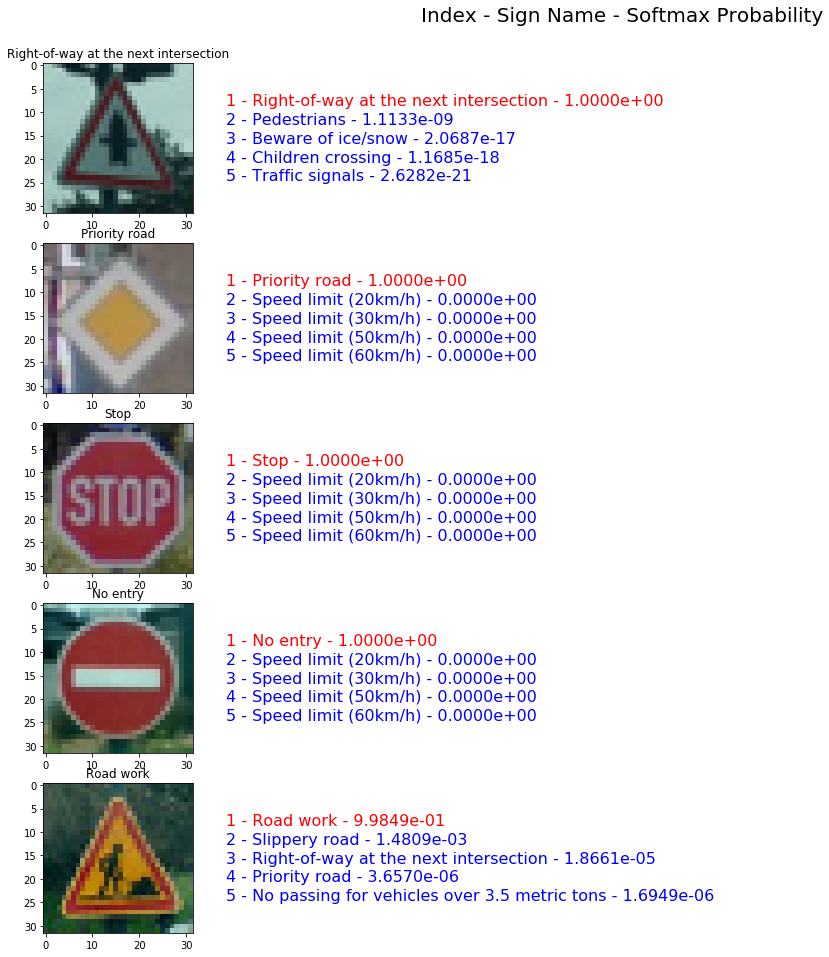

In [47]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

top5 = tf.nn.top_k(softmax_probabilities,k=5)
with tf.Session() as sess:
    top_five = sess.run(top5)
    topfiveprob = top_five.values
    topfiveind = top_five.indices
    #print(top_five)
    print('Probability:')
    print(topfiveprob)
    print('Indices:')
    print(topfiveind)
    fig=plt.figure(figsize=(16, 16))   
    for pred,i in zip(predicts, range(len(predicts))):
        top5prob = topfiveprob[i]
        top5ind = topfiveind[i]
        ax = fig.add_subplot(5, 1, i+1)
        ax.title.set_text(signnames[i])
        plt.imshow(X_verify[i])
        if i==0:            
            textstr = "%s - %s - %s\n\n"%("Index","Sign Name","Softmax Probability")
            plt.text(80, 0, textstr, fontsize=20)  
        for ind in range(5):
            signlabel, signname = find_sign(top5ind[ind], \
                                    traffic_sign_file)
            if signname=='not matched':
                print(signname)
                sys.exit()
            textstr = "%d - %s - %s\n\n"%(ind+1,signname,str("{:.4e}".format(float(top5prob[ind]))))
            if ind==0:
                c = 'red'
            else:
                c = 'blue'
            plt.text(X_verify[i].shape[0]*1.2, \
                     X_verify[i].shape[1]/2+X_verify[i].shape[1]*ind/8, \
                     textstr, fontsize=16, color=c)       
    plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


(32, 32, 3)


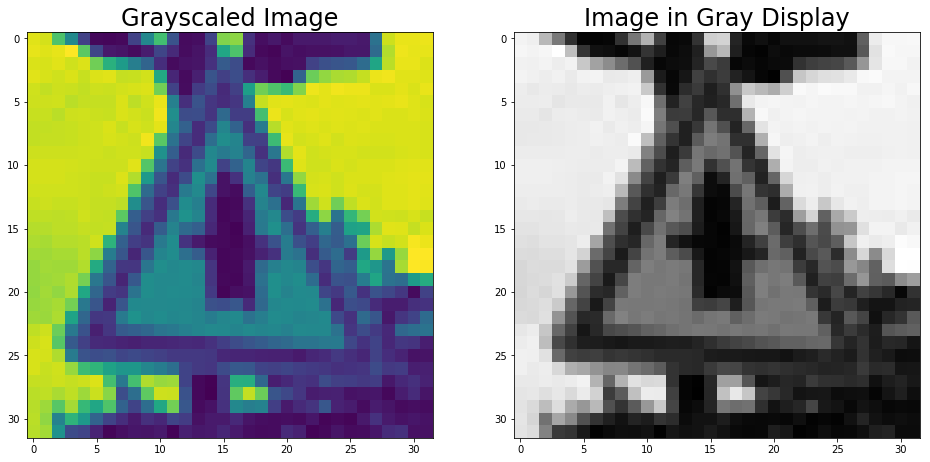

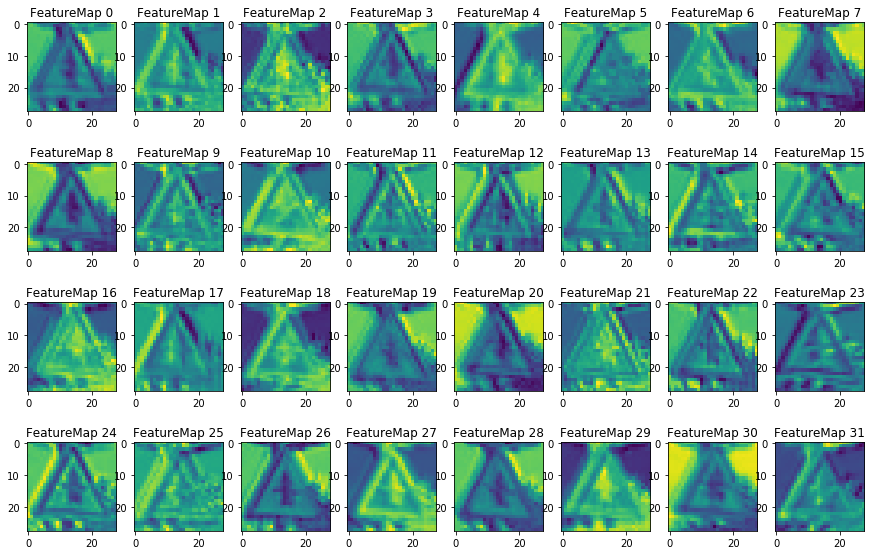

In [48]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            #plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max)
        elif activation_max != -1:
            #plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max)
        elif activation_min !=-1:
            #plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min)
        else:
            #plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest")

img = np.zeros((1,32,32,3))
print(X_verify[0].shape)
img[0,:,:,:] = np.array(X_verify[0])
fig=plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Grayscaled Image", fontsize=24)
plt.imshow(np.squeeze(np.array(X_verifygray[0])))
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Image in Gray Display", fontsize=24)
plt.imshow(np.squeeze(np.array(X_verifygray[0])),cmap='gray')
plt.show()
outputFeatureMap(img, c2)